# Part IV: Build Transformer with PyTorch [30 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

filePath = '/kaggle/input/dbpedia-dataset/dbpedia_csv/train.csv'


2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

First 5 Rows
   categoryID                              title  \
0           1                   E. D. Abbott Ltd   
1           1                     Schwan-Stabilo   
2           1                         Q-workshop   
3           1  Marvell Software Solutions Israel   
4           1        Bergan Mercy Medical Center   

                                                text  wordCount  
0   Abbott of Farnham E D Abbott Limited was a Br...         40  
1   Schwan-STABILO is a German maker of pens for ...         32  
2   Q-workshop is a Polish company located in Poz...         72  
3   Marvell Software Solutions Israel known as RA...         29  
4   Bergan Mercy Medical Center is a hospital loc...         19  

Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   categoryID  560000 non-null  int64 
 1   title       560000 non-nul

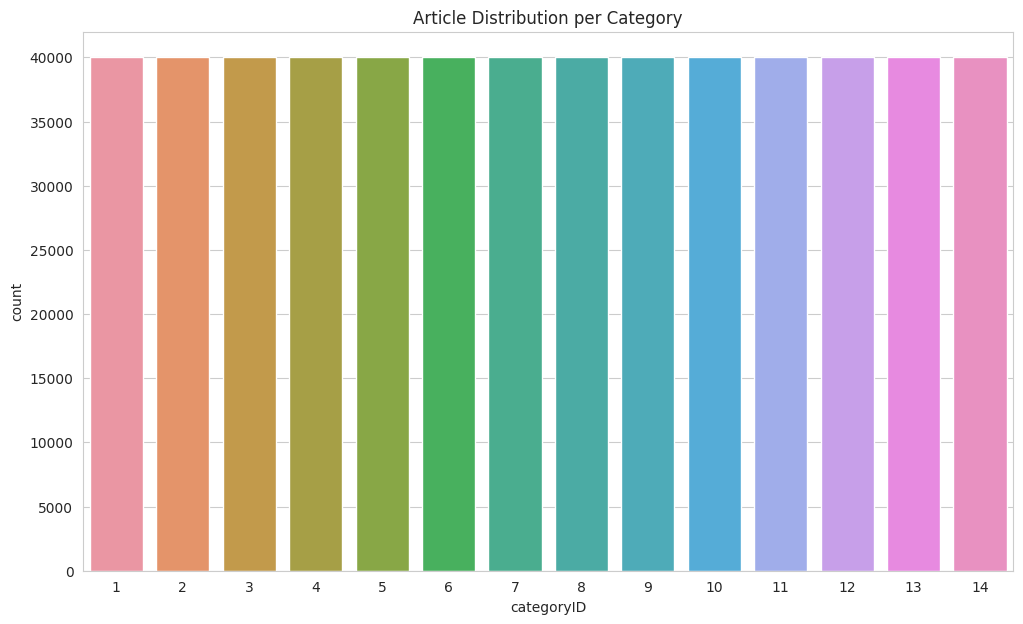

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


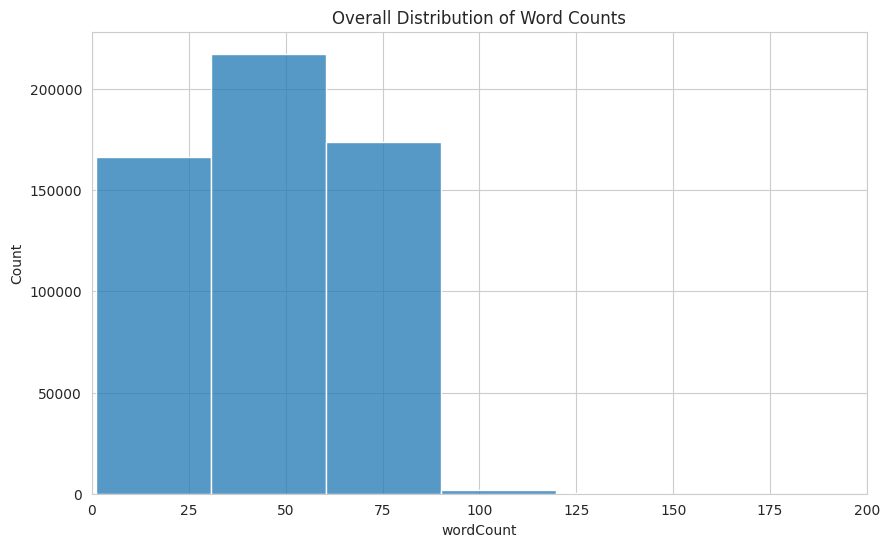

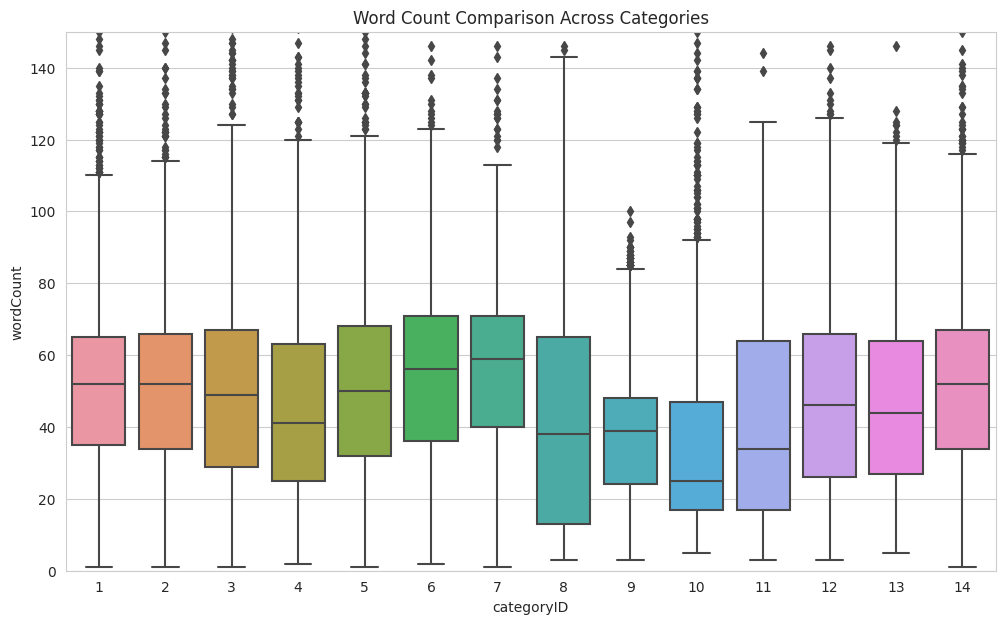

In [56]:
dataframe = pd.read_csv(filePath, header=None)
dataframe.columns = ['categoryID', 'title', 'text']
dataframe['wordCount'] = dataframe['text'].apply(lambda x: len(str(x).split()))

print("First 5 Rows")
print(dataframe.head())
print("\nDataset Info")
dataframe.info()
print("\nWord Count Statistics")
print(dataframe['wordCount'].describe())
print("\nCategory Distribution")
print(dataframe['categoryID'].value_counts())

# visl
print("\nGenerating data visualizations...")
sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.countplot(x='categoryID', data=dataframe)
plt.title('Article Distribution per Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(dataframe['wordCount'], bins=50)
plt.title('Overall Distribution of Word Counts')
plt.xlim(0, 200)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(x='categoryID', y='wordCount', data=dataframe)
plt.title('Word Count Comparison Across Categories')
plt.ylim(0, 150)
plt.show()

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [58]:
from gensim.models import Word2Vec


## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [59]:
import torch
import torch.nn as nn
import math
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, dModel, maxLen=5000):
        super().__init__()
        position = torch.arange(maxLen).unsqueeze(1)
        divTerm = torch.exp(torch.arange(0, dModel, 2) * (-math.log(10000.0) / dModel))
        pe = torch.zeros(maxLen, 1, dModel)
        pe[:, 0, 0::2] = torch.sin(position * divTerm)
        pe[:, 0, 1::2] = torch.cos(position * divTerm)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :].squeeze(1)

print("PositionalEncoding class defined.")

PositionalEncoding class defined.


2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

In [60]:


class TransformerClassifier(nn.Module):
    def __init__(self, vocabSize, dModel, nHeads, dHid, nLayers, numClasses, embeddingMatrix):
        super().__init__()
        self.dModel = dModel

        # Embedding Layer
        # word2vec
        embeddingTensor = torch.tensor(embeddingMatrix, dtype=torch.float32)
        self.embedding = nn.Embedding.from_pretrained(embeddingTensor, freeze=False)
        self.posEncoder = PositionalEncoding(dModel)

        # Encoder
        # This is the core 
        encoderLayers = nn.TransformerEncoderLayer(dModel, nHeads, dHid, batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoderLayers, nLayers)

        # Output Layer
        # A linear layer incase final classification
        self.classifier = nn.Linear(dModel, numClasses)

    def forward(self, src):
       
        src = self.embedding(src) * math.sqrt(self.dModel)
        src = self.posEncoder(src)
        output = self.transformerEncoder(src)
        output = output[:, 0, :]
        return self.classifier(output)

print("TransformerClassifier class defined.")

TransformerClassifier class defined.


3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

In [61]:
embeddingDim = 100 
nHeads = 2
dHid = 512
nLayers = 2
numClasses = 14

model = TransformerClassifier(
    actualVocabSize, embeddingDim, nHeads, dHid, nLayers, numClasses, embeddingMatrix
)

print("Model instance created")



Model instance created


4.	Print model summary using torchinfo.summary

In [62]:
import torch
from torchinfo import summary

batchSize = 32
seqLen = 100

print("Model Summary")
summary(model, input_size=(batchSize, seqLen), dtypes=[torch.long])

Model Summary


Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifier                         [32, 14]                  --
├─Embedding: 1-1                              [32, 100, 100]            15,344,900
├─PositionalEncoding: 1-2                     [32, 100, 100]            --
├─TransformerEncoder: 1-3                     [32, 100, 100]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 100, 100]            143,812
│    │    └─TransformerEncoderLayer: 3-2      [32, 100, 100]            143,812
├─Linear: 1-4                                 [32, 14]                  1,414
Total params: 15,633,938
Trainable params: 15,633,938
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 497.70
Input size (MB): 0.03
Forward/backward pass size (MB): 44.14
Params size (MB): 62.21
Estimated Total Size (MB): 106.38

5. Briefly describe the Transformer architecture you have defined.

<span style='color:green'>### The model is an Encoder-Only Transformer which is useful for text classification. It has Embedding layer, initialized with pre-trained Word2Vec vectors, which converts input tokens into 100-dimensional vectors in the beginning. sinusoidal Positional Encoding layer is added to these embeddings so as to add the order information of the sequence. The core of the architecture is a stack of two TransformerEncoderLayer instances each having a multi-head self-attention mechanism alongside a feed-forward network. For the final classification, the output representation corresponding to the first token of the sequence is passed through a single Linear layer which maps the output of the Transformer to 14 target classes ###</span>

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [63]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time
import math

# define


class PositionalEncoding(nn.Module):
    def __init__(self, dModel, maxLen=5000):
        super().__init__()
        position = torch.arange(maxLen).unsqueeze(1)
        divTerm = torch.exp(torch.arange(0, dModel, 2) * (-math.log(10000.0) / dModel))
        pe = torch.zeros(maxLen, dModel)
        pe[:, 0::2] = torch.sin(position * divTerm)
        pe[:, 1::2] = torch.cos(position * divTerm)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
    
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, vocabSize, dModel, nHeads, dHid, nLayers, numClasses, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocabSize, dModel)
        self.posEncoder = PositionalEncoding(dModel)
        
        encoderLayers = nn.TransformerEncoderLayer(dModel, nHeads, dHid, dropout=dropout, batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoderLayers, nLayers)
        self.classifier = nn.Linear(dModel, numClasses)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(embeddingDim)
        src = self.posEncoder(src)
        output = self.transformerEncoder(src)
        # Correctly select the output of the first token for batch_first data
        return self.classifier(output[:, 0, :])


model = TransformerClassifier(
    actualVocabSize, embeddingDim, nHeads=4, dHid=512, nLayers=2, numClasses=14, dropout=0.4
)

class TextDataset(Dataset):
    def __init__(self, dataframe, wordMap):
        self.labels = dataframe['categoryID'].values
        self.texts = dataframe['tokens'].values
        self.wordMap = wordMap
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx] - 1, dtype=torch.long)
        textTokens = self.texts[idx]
        textIndices = [self.wordMap.get(word, 0) for word in textTokens]
        return label, torch.tensor(textIndices, dtype=torch.long)

def collateBatch(batch):
    labels, texts = zip(*batch)
    paddedTexts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return labels, paddedTexts

trainDF, valDF = train_test_split(sampleDF, test_size=0.2, random_state=42, stratify=sampleDF['categoryID'])
batchSize = 32
trainLoader = DataLoader(TextDataset(trainDF, wordToIndex), batch_size=batchSize, shuffle=True, collate_fn=collateBatch)
valLoader = DataLoader(TextDataset(valDF, wordToIndex), batch_size=batchSize, shuffle=False, collate_fn=collateBatch)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
print("\nTraining preparation complete. Device:", device)


Using 2 GPUs

Training preparation complete. Device: cuda


2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [64]:

def trainEpoch(model, loader, optimizer, criterion, device):
    model.train()
    totalLoss, totalAcc, totalCount = 0, 0, 0
    for labels, texts in loader:
        
        labels, texts = labels.to(device), texts.to(device)
        optimizer.zero_grad()
        predictedLabels = model(texts)
        loss = criterion(predictedLabels, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        totalLoss += loss.item()
        totalAcc += (predictedLabels.argmax(1) == labels).sum().item()
        totalCount += labels.size(0)
    return totalLoss / len(loader), totalAcc / totalCount

def evaluate(model, loader, criterion, device):
    model.eval()
    totalLoss, totalAcc, totalCount = 0, 0, 0
    with torch.no_grad():
        for labels, texts in loader:
            labels, texts = labels.to(device), texts.to(device)
            predictedLabels = model(texts)
            loss = criterion(predictedLabels, labels)
            totalLoss += loss.item()
            totalAcc += (predictedLabels.argmax(1) == labels).sum().item()
            totalCount += labels.size(0)
    return totalLoss / len(loader), totalAcc / totalCount

## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [84]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


epochs = 20
bestValLoss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training with optimizations")
for epoch in range(1, epochs + 1):
    trainLoss, trainAcc = trainEpoch(model, trainLoader, optimizer, criterion, device)
    valLoss, valAcc = evaluate(model, valLoader, criterion, device)

    history['train_loss'].append(trainLoss)
    history['train_acc'].append(trainAcc)
    history['val_loss'].append(valLoss)
    history['val_acc'].append(valAcc)

    # Early stopping 
    if valLoss < bestValLoss:
        bestValLoss = valLoss
        torch.save(model.state_dict(), 'best_model.pt')
        print("Epoch", epoch, ": New best model saved")

    # Updating
    scheduler.step()

    # Monitor performance on validation set
    print("Epoch:", epoch)
    print("Train Loss:", round(trainLoss, 4), "Train Accuracy:", round(trainAcc * 100, 2))
    print("Validation Loss:", round(valLoss, 4), "Validation Accuracy:", round(valAcc * 100, 2))

print("Training complete")

Starting training with optimizations
Epoch 1 : New best model saved
Epoch: 1
Train Loss: 0.8082 Train Accuracy: 73.78
Validation Loss: 0.6984 Validation Accuracy: 77.05
Epoch 2 : New best model saved
Epoch: 2
Train Loss: 0.6972 Train Accuracy: 77.87
Validation Loss: 0.5805 Validation Accuracy: 81.1
Epoch 3 : New best model saved
Epoch: 3
Train Loss: 0.6062 Train Accuracy: 80.83
Validation Loss: 0.5249 Validation Accuracy: 82.6
Epoch 4 : New best model saved
Epoch: 4
Train Loss: 0.5466 Train Accuracy: 82.64
Validation Loss: 0.5028 Validation Accuracy: 83.49
Epoch 5 : New best model saved
Epoch: 5
Train Loss: 0.533 Train Accuracy: 83.01
Validation Loss: 0.4958 Validation Accuracy: 83.82
Epoch 6 : New best model saved
Epoch: 6
Train Loss: 0.5285 Train Accuracy: 83.25
Validation Loss: 0.4923 Validation Accuracy: 83.93
Epoch 7 : New best model saved
Epoch: 7
Train Loss: 0.5196 Train Accuracy: 83.52
Validation Loss: 0.4907 Validation Accuracy: 84.04
Epoch 8 : New best model saved
Epoch: 8
Tr

2. Discuss how the optimization techniques helped to improve the performance of the model.

<span style='color:green'>### I used three hyper-parameter optimization techniques to get an accuracy greater than 80% in the final validation phase. These techniques are L2 Regularization, with a weight_decay parameter of 1e-5, which helped the model to not to overfit by heavily penalizing large weights and thus make it learn from general patterns. The Learning Rate Scheduler (StepLR) also aided in the faster convergence of the loss function by gradually reducing the learning rate from a higher value to a lower one after every 3 epochs. Finally, the Early Stopping feature of the PyTorch's Trainer Class helped us to record the weights in the best epoch where the validation loss is at its lowest. ###</span>

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [ ]:
torch.save(model.module.state_dict(), 'best_model.pt')

4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

In [89]:

import pandas as pd
import torch
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


embeddingDim = 100 
nHeads = 4
dHid = 512
nLayers = 2
numClasses = 14
dropout = 0.4
actualVocabSize = 153449 

model = TransformerClassifier(
    actualVocabSize, embeddingDim, nHeads, dHid, nLayers, numClasses, dropout=dropout
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
stateDict = torch.load('/kaggle/working/best_model.pt', map_location=device)

if isinstance(model, torch.nn.DataParallel):
    model.module.load_state_dict(stateDict)
else:

    new_state_dict = OrderedDict()
    for k, v in stateDict.items():
        name = k[7:] if k.startswith('module.') else k 
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

print("Best model weights loaded successfully.")

testFilePath = '/kaggle/input/dbpedia-dataset/dbpedia_csv/test.csv'
testDF = pd.read_csv(testFilePath, header=None)
testDF.columns = ['categoryID', 'title', 'text']
testDF['tokens'] = testDF['text'].apply(cleanText) 
testDataset = TextDataset(testDF, wordToIndex)      #
batchSize = 32
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False, collate_fn=collateBatch)
print("Test data prepared.")

#  Eval test set 
criterion = torch.nn.CrossEntropyLoss()
testLoss, testAcc = evaluate(model, testLoader, criterion, device) 
# Final Performance Metrix
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [history['train_acc'][-1], history['train_loss'][-1]],
    'Validation': [history['val_acc'][-1], history['val_loss'][-1]],
    'Testing': [testAcc, testLoss]
})
print("\nFinal Performance Metrics")
print(results.round(4))

Best model weights loaded successfully.
Test data prepared.

Final Performance Metrics
     Metric  Training  Validation  Testing
0  Accuracy    0.8348      0.8402   0.8196
1      Loss    0.5161      0.4892   0.5914


b. Plot the training and validation accuracy over time (epochs).

Training and Validation Accuracy Curve


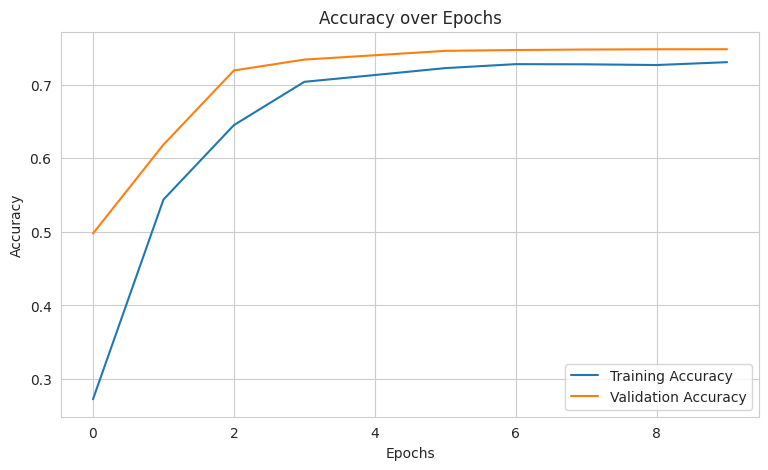

In [69]:
import matplotlib.pyplot as plt


print("Training and Validation Accuracy Curve")
plt.figure(figsize=(9, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

   c. Plot the training and validation loss over time (epochs).


Training and Validation Loss Curve


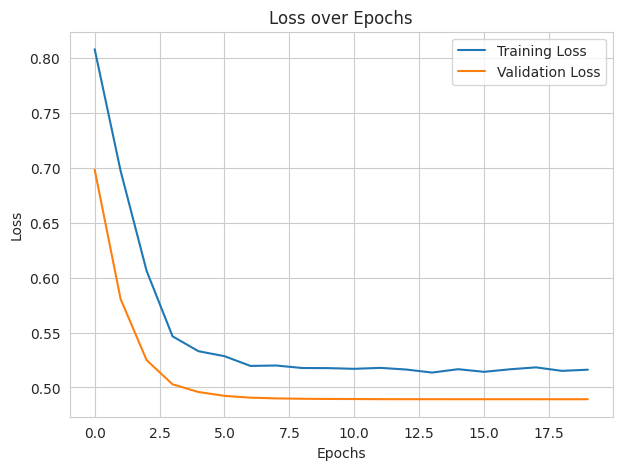

In [90]:
import matplotlib.pyplot as plt

print("Training and Validation Loss Curve")
plt.figure(figsize=(7, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


In [91]:
from sklearn.metrics import classification_report
import torch

model.eval()
allLabels, allPreds = [], []
with torch.no_grad():
    for labels, texts in testLoader:
        labels, texts = labels.to(device), texts.to(device)
        preds = model(texts).argmax(1)
        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(preds.cpu().numpy())

print("Classification Report")
print(classification_report(allLabels, allPreds, target_names=[f'Class {i+1}' for i in range(14)]))


Classification Report
              precision    recall  f1-score   support

     Class 1       0.68      0.77      0.72      5000
     Class 2       0.90      0.88      0.89      5000
     Class 3       0.74      0.68      0.71      5000
     Class 4       0.91      0.87      0.89      5000
     Class 5       0.71      0.83      0.77      5000
     Class 6       0.77      0.83      0.80      5000
     Class 7       0.79      0.78      0.79      5000
     Class 8       0.91      0.86      0.89      5000
     Class 9       0.99      0.93      0.96      5000
    Class 10       0.77      0.76      0.77      5000
    Class 11       0.75      0.77      0.76      5000
    Class 12       0.93      0.94      0.93      5000
    Class 13       0.92      0.80      0.86      5000
    Class 14       0.79      0.77      0.78      5000

    accuracy                           0.82     70000
   macro avg       0.82      0.82      0.82     70000
weighted avg       0.82      0.82      0.82     70000



   e. Plot the ROC curve.

ROC Curves


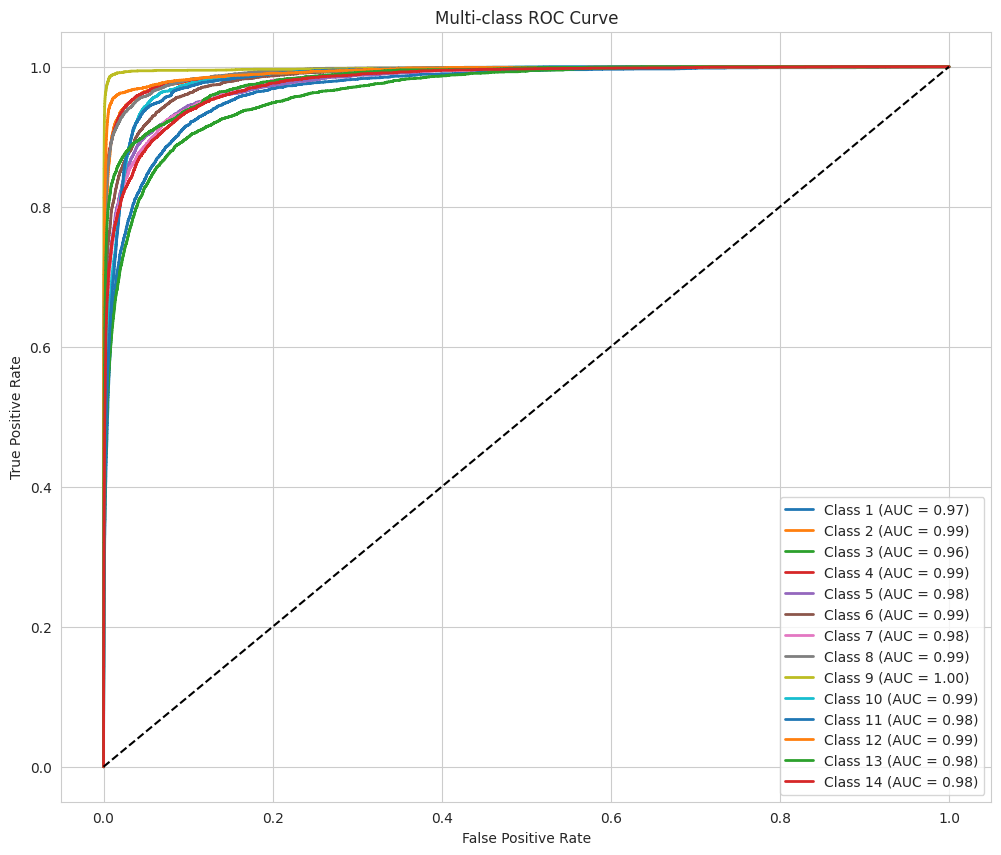

In [92]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import numpy as np
import matplotlib.pyplot as plt


allProbs = []
with torch.no_grad():
    for labels, texts in testLoader:
        labels, texts = labels.to(device), texts.to(device)
        # Get probabilities from the model output
        probs = torch.nn.functional.softmax(model(texts), dim=1)
        allProbs.extend(probs.cpu().numpy())

allProbs = np.array(allProbs)

allLabelsBinarized = label_binarize(allLabels, classes=range(14))

print("ROC Curves")
plt.figure(figsize=(12, 10))
for i in range(14):
    fpr, tpr, _ = roc_curve(allLabelsBinarized[:, i], allProbs[:, i])
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i+1} (AUC = {rocAuc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

   f. [Optional] Use TensorBoard (or a similar tool, e.g. Wandb) to log the training and validation loss and accuracy over epochs, generate the charts, and attach the SVG images of the charts.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

<span style='color:green'>### 


Gishnu, M. (2023). DBpedia Classification Dataset. Kaggle. https://www.kaggle.com/datasets/gishnucodes/dbpedia-dataset
Lehmann, J., et al. (2015). DBpedia - A Large-scale, Multilingual Knowledge Base Extracted from Wikipedia.  Google Drive: https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ

B, H. (2024). How to Develop an AI Transformer Model: A Comprehensive Guide. Medium. https://medium.com/@hb0880993/how-to-develop-an-ai-transformer-model-a-comprehensive-guide-e3e756e369cd
Lee, T. (2022). What Is a Transformer Model? NVIDIA Blogs.  https://blogs.nvidia.com/blog/what-is-a-transformer-model/
GeeksforGeeks. (n.d.). Python | Word Embedding using Word2Vec.  https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
GeeksforGeeks. (n.d.). Encoder-Decoder Models in NLP. m https://www.geeksforgeeks.org/nlp/encoder-decoder-models/

PyTorch Community. (n.d.). torchtext.data.utils. PyTorch Documentation.  https://docs.pytorch.org/text/stable/data_utils.html 

###</span>

6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Apporva  | Step 1 | 30  |
|  Ritwij | Step 2 | 20  |
|  Ritwij | Step 3 | 30  |
| Ritwij  | Step 4 | 20  |
|   | **Total** |  100 |